# Учебный проект 13_Прогнозирование температуры звезды

## Содержание

* [Описание проекта](#Описание)
* [Импорт библиотек Python](#Импорт)
* [Загрузка данных](#Загрузка)
* [Предобработка данных](#Предобработка)
* [Исследовательский анализ данных](#Исследование)
    * [Количественные показатели](#Исследование_количество)
    * [Качественные показатели](#Исследование_качество)

## Описание проекта <a class = 'anchor' id = 'Описание'></a>

На исследовании находятся данные с `показателями космических объектов, - звезд` - которые были предоставлены руководством компании "Небо на ладони".

---

`Задача`

Разработать модель нейронной сети для **прогнозирования температуры на поверхности звезды**.

---

`Путь решения`

1. Собрать данные с характеристиками звезд;
2. Провести предобработку значений в наборах данных;
3. Провести исследовательский анализ данных для выявления закономерностей, применимых к последующей настройке модели нейронной сети;
4. Подготовить выборки для обучения моделей;
5. Построить baseline модели нейронной сети для получения предварительных результатов;
6. Подготовить улучшенную версию нейронной сети с перебором следующих параметров:
    * Dropout;
    * BatchNormalization;
    * Размер батча;
    * Количество эпох.
7. Сформировать вывод о подготовленных решениях. Выполнить сравнение двух версий модели нейронной сети.

---

`Располагаемые данные`

**Данные, описывающие показатели звезд**

* Относительная светимость L/Lo - светимость звезды относительно Солнца;
* Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца;
* Абсолютная звездная величина Mv — физическая величина, характеризующая блеск звезды;
* Звездный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа;
* Тип звезды:

|Тип звезды|Номер, соответствующий типу|
|----------|---------------------------|
|Коричневый карлик|0|
|Красный карлик|1|
|Белый карлик|2|
|Звезды главной последовательности|3|
|Сверхгигант|4|
|Гипергигант|5|

**Целевой признак**
* Абсолютная температура Т(К) - температура поверхности звезды в Кельвинах.

**Справочная информация**
* Светимость Солнца (Lo) = 3.828 * 10**26;
* Радиус Солнца (Ro) = 6.9551 * 10**8.

## Импорт библиотек Python <a class = 'anchor' id = 'Импорт'></a>

1. Импорт библиотек Python:
    * для манипулирования данными;
    * для визуализации данных;
    * для решения задач машинного обучения:
        * механизмы построения нейронных сетей;
        * метрики оценки эффективности моделей;
        * механизмы отбора данных;
        * механизмы подготовки данных.
2. Инициализация переменных-констант для последующего использования на этапе построения моделей МО;
3. Формирование вывода по итогам данного этапа.

In [1]:
# импорт библиотек python

# для манипулирования данными
import pandas as pd
import numpy as np

# для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import dash
from textwrap import fill
# установка размеров для последующих графиков в проекте
plt.rcParams['figure.figsize'] = (10, 5)

# вычисление корреляции данных
from phik import phik_matrix

# импорт библиотеки для построения нейронной сети
from torch import nn

# метрики оценки эффективности моделей
from sklearn.metrics import (mean_squared_error, 
                            root_mean_squared_error)

# механизмы отбора данных и подбора параметров моделей
from sklearn.model_selection import train_test_split

# механизмы подготовки данных
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder)

In [2]:
# инициализация констант для дальнейшего использования в проекте
# инициализация переменной RANDOM_STATE для фиксирования "случайности"
RANDOM_STATE = 42
# инициализация переменной TEST_SIZE для разделения выборки на обучающую и тестовую
TEST_SIZE = 0.25

**Вывод**

1. Импортированы библиотеки Python:
    * для манипулирования данными:
        * pandas;
        * numpy.
    * для визуализации данных:
        * matplotlib.pyplot;
        * seaborn;
        * plotly;
        * dash.
    * для вычисления корреляции данных:
        * phik_matrix.
    * для решения задач машинного обучения:
        * механизмы построения нейронной сети:
            * torch.nn.
        * метрики оценки эффективности моделей классификации;
        * train_test_split - механизм разделения данных;
        * StandardScaler - стандартизация данных;
        * OneHotEncoder - one-hot кодирование категориальных признаков;
        * OrdinalEncoder - кодирование значений ранговых признаков.
2. Инициализированы переменные **RANDOM_STATE** и **TEST_SIZE** для фиксирования "случайности" и размера тестовой выборки.

## Загрузка данных <a class = 'anchor' id = 'Загрузка'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Загрузка данных в рабочую среду Jupyter Notebook. Инициализация переменной **stars**;
2. Вывод на экран параметров датасетов:
    * вывод общей структуры набора данных - демонстрация первых 5 строк;
    * общей информации о наборе данных;
    * визуализация распределений количественных показателей.
3. Формирование вывода по итогам данного этапа.

In [3]:
# загрузка данных в рабочую среду

try:
    stars = pd.read_csv('~/Desktop/YandexPraktikum_projects/datasets/6_class.csv')
except:
    stars = pd.read_csv('/datasets/6_class.csv')

In [4]:
# инициализация пользовательской функции для первичного изучения содержимого наборов данных
def first_meeting (df : pd.DataFrame, df_name : str) -> None:
    print(f'Структура набора данных {df_name}')
    display(df.head())
    print('Общая информация о наборе')
    print(df.info())
    print()

In [5]:
# инициализация пользовательской функции построения распределений количественных непрерывных показателей
def num_distribution(df : pd.DataFrame, column : str, bins : int):
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения признака {column}')
    plt.ylabel(f'Частота значений признака')
    plt.title(f'Гистограмма значений {column}', fontsize = 10)
    sns.histplot(df, x = column, bins = bins)
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения признака {column}')
    plt.title(f'Диаграмма размаха значений {column}', fontsize = 10)
    sns.boxplot(df, x = column)
    plt.grid(False)
    plt.show()

In [6]:
# инициализация пользовательской функции построения диаграмм количественных дискретных показателей
def num_countplot(df : pd.DataFrame, column : str):
    sns.countplot(df, x = column)
    plt.title(f'Столбчатая диаграмма значений признака {column}', fontsize = 12)
    plt.xlabel(f'Признак {column}')
    plt.xticks(rotation = 45)
    plt.ylabel(f'Количество значений признака')
    plt.show()

Структура набора данных stars


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


Общая информация о наборе
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.3+ KB
None



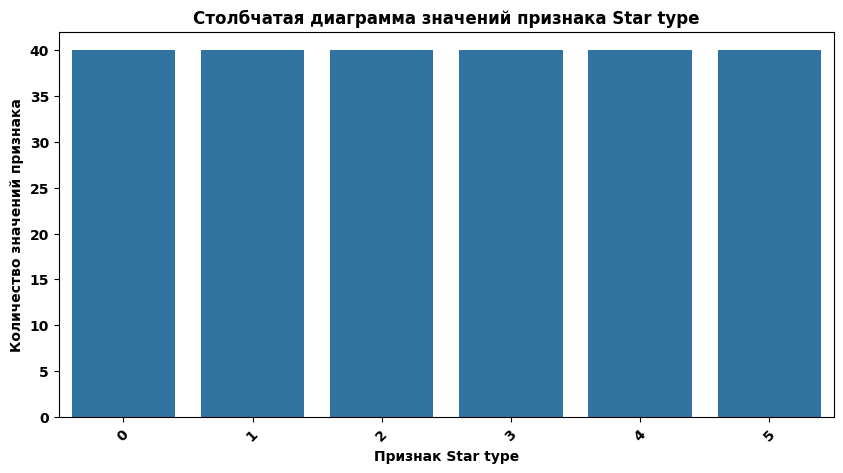

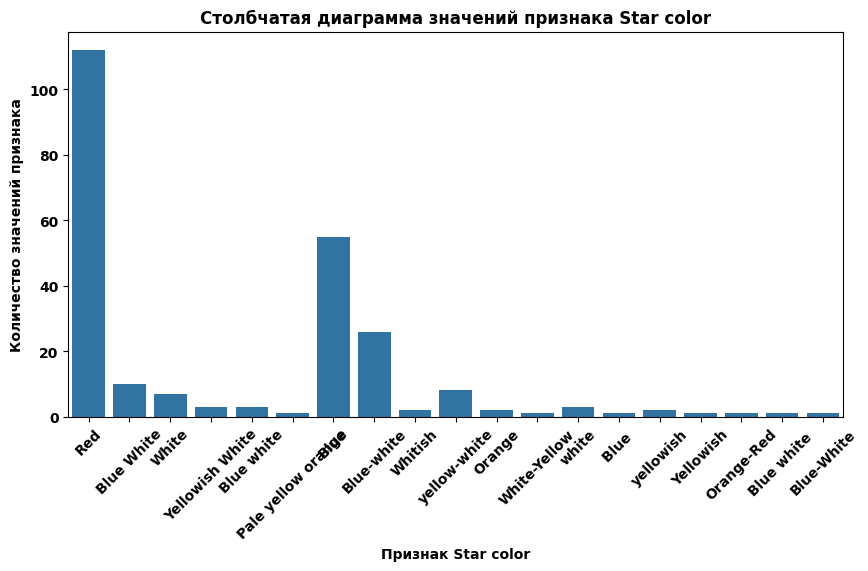

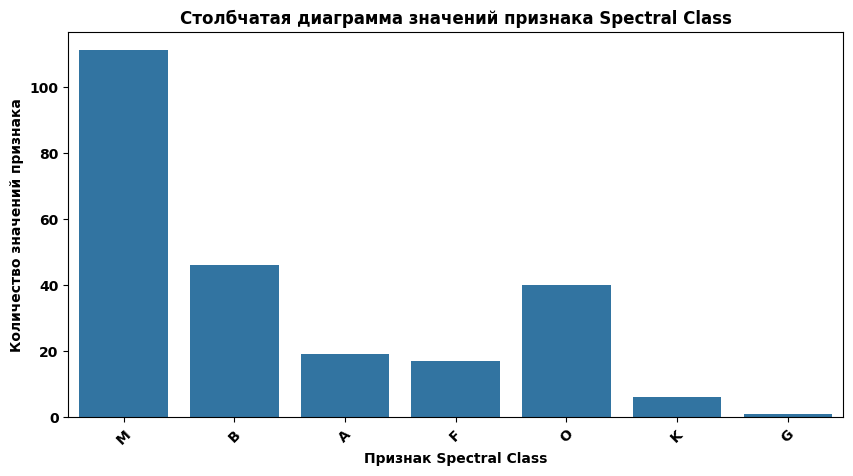

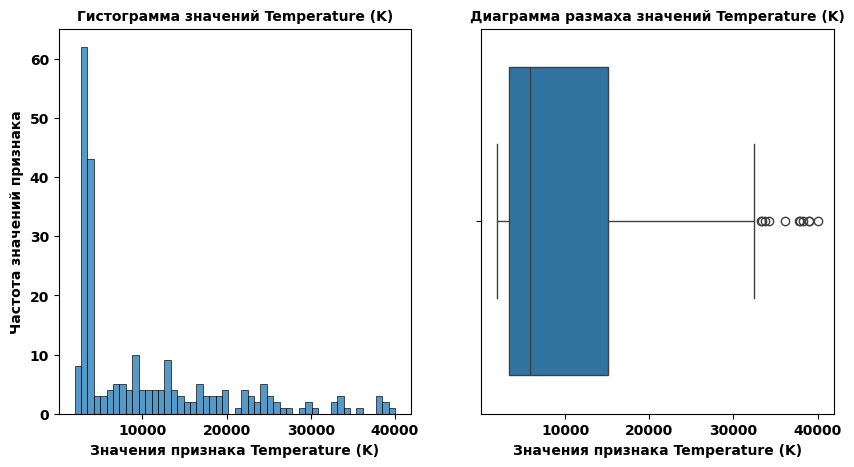

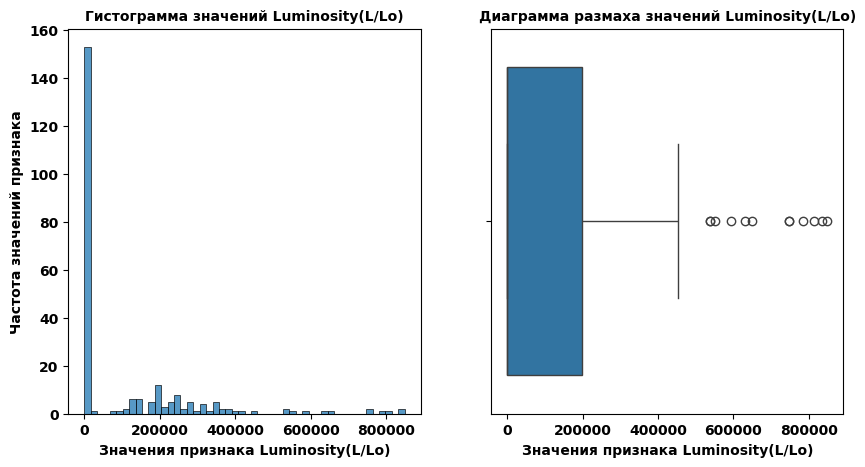

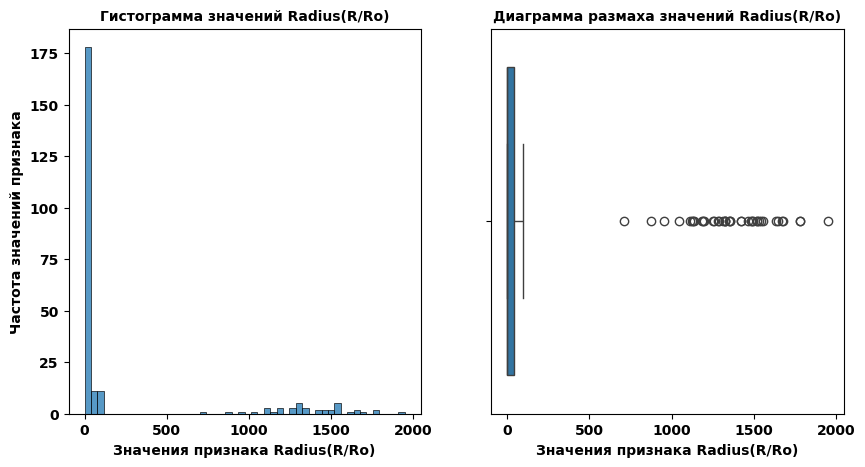

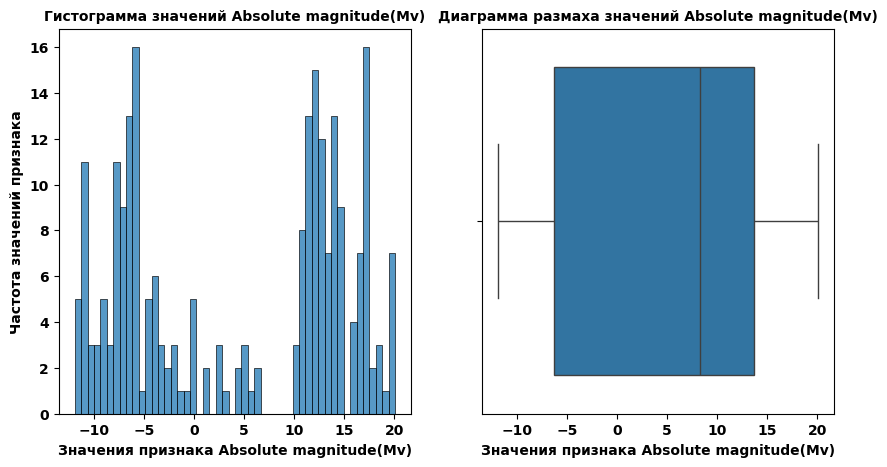

In [7]:
# вывод на экран параметров датасета 'autos'
first_meeting(stars, 'stars')

# вывод на экран графиков дискретных величин по набору 'autos'
for col in ['Star type', 'Star color', 'Spectral Class']:
    num_countplot(stars, col)

# вывод на экран графиков непрерывных количественных величин по набору 'autos'
for col in ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']:
    num_distribution(stars, col, 50)

**Вывод**

1. Произведена загрузка данных в рабочую среду Jupyter Notebook. Инициализирована переменная **stars**;
2. Выведены на экран параметры датасета:
    * В наборе данных **отсутствуют пустые значения** по признакам;
    * Типы данных **соответствуют сущностям значений** по всем рассматриваемым признакам;
    * Названия столбцов **необходимо привести к формату snake_case**;
    * Наблюдаются неявные дубликаты по признаку **Star color**;
    * Наблюдаются выбросы по количественным признакам:
        * **Temperature (K)**;
        * **Luminosity (L/Lo)**;
        * **Radius (R/Ro)**.
    * Самые популярные категории по спектральному классу: **M, B** и **O**;
    * Самые популярные цвета звезд: **Red**, **Pale yellow orange** и **Blue**.

## Предобработка данных <a class = 'anchor' id = 'Предобработка'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Приведение названий столбцов к формату snake_case;
2. Обработка неявных дубликатов - значений - по признаку **Star color**;
3. Проверка датасетов на явные дубликаты;
4. Формирование вывода по итогам данного этапа.

In [ ]:
# преобразование названий столбцов к формату snake_case
stars.columns = ['_'.join(col.lower().split(' ')) for col in stars.columns]

stars = stars.rename(columns = {
    'temperature_(k)':'temperature',
    'luminosity(l/lo)':'luminosity',
    'radius(r/ro)':'radius',
    'absolute_magnitude(mv)':'absolute_magnitude'
})

Index(['temperature', 'luminosity', 'radius', 'absolute_magnitude',
       'star_type', 'star_color', 'spectral_class'],
      dtype='object')

In [ ]:
# преобразование значений по признаку 'star_color'
stars['star_color'] = (
    stars['star_color']
    .str.lower() # понижение регистра
    .str.strip() # исключение пробелов с конца строк
    .str.replace(' ', '-') # замена знака разделителя
)

# замена значений с перестановкой цвета
stars.loc[stars['star_color'] == 'yellow-white', 'star_color'] = 'white-yellow'

['blue',
 'blue-white',
 'orange',
 'orange-red',
 'pale-yellow-orange',
 'red',
 'white',
 'white-yellow',
 'whitish',
 'yellowish',
 'yellowish-white']

In [21]:
# проверка датасета на явные дубликаты
print('Количество явных дубликатов в наборе данных:', stars.duplicated().sum())
print('Доля дубликатов от общего количества записей в наборе: {:.1%}'.format(stars.duplicated().sum() / stars.shape[0]))

Количество явных дубликатов в наборе данных: 0
Доля дубликатов от общего количества записей в наборе: 0.0%


**Вывод**

1. Названия столбцов приведены к формату snake_case;
2. Обработаны неявные дубликаты - значения - по признаку **Star color**:
    * Понижен регистр значений;
    * Удалены пробелы в конце строк;
    * Заменены пробелы на дефис;
    * Заменены значения с перестановкой цвета.
3. Проверка датасетов на явные дубликаты - **Явные дубликаты отсутствуют**;
4. Набор данных подготовлен к дальнейшему исследовательскому анализу.